# Day3.3 CNN (Convolutional Neural Network)

### 실습 목표
- CIFAR-10 데이터셋을 분류하기 위한 CNN이 PyTorch에서 어떻게 구현되는지 확인
<details>
<summary>데이터셋 상세</summary>

  - 일상에서 발견할 수 있는 Object들에 대한 32x32 크기의 컬러 이미지

  - 총 10개의 클래스
  
  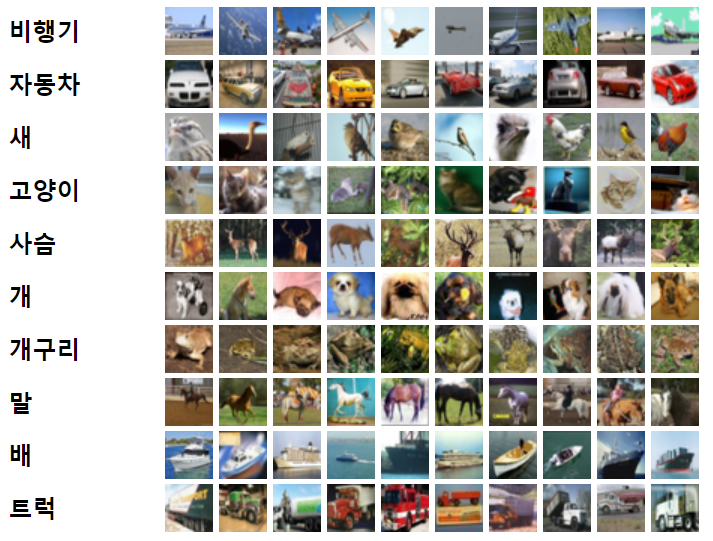

</details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



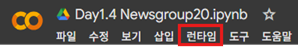

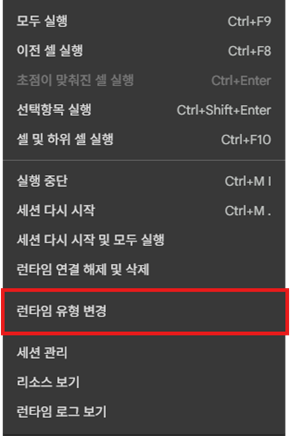

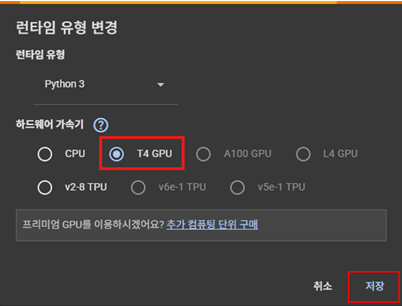

- 필요한 라이브러리 설치 및 호출

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm

- GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. CIFAR-10 데이터셋 준비

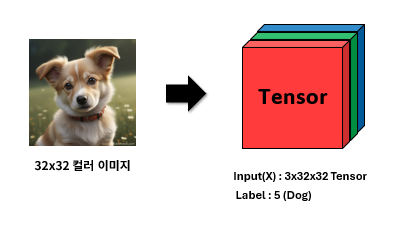

- 32x32 크기의 총 6만장 (Train 5만장, Test 1만장)의 컬러 이미지로 구성된 데이터 셋
- 일상에서 쉽게 확인할 수 있는 총 10개의 Class를 가지고 있음
- CIFAR-10의 경우 컬러 이미지 (R,G,B 채널을 가짐) 이므로, ToTensor로 변환하면 [C,H,W]=[3,32,32] 크기의 Tensor가 됨

In [4]:
# ToTensor + Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 불러오기
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dataloader 구축
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


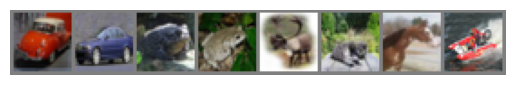

Labels: automobile | automobile | frog | frog | deer | cat | horse | ship


In [5]:
# 불러온 데이터 확인
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Dataloader에서 일부 이미지 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 첫 8개 이미지 출력
images = torchvision.utils.make_grid(images[:8], nrow=8)
img = images / 2 + 0.5  # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.show()
print('Labels:', ' | '.join(classes[labels[i]] for i in range(8)))

## 2. CNN 모델 구축, 학습, 평가

#### 2.1 CNN 모델 구축

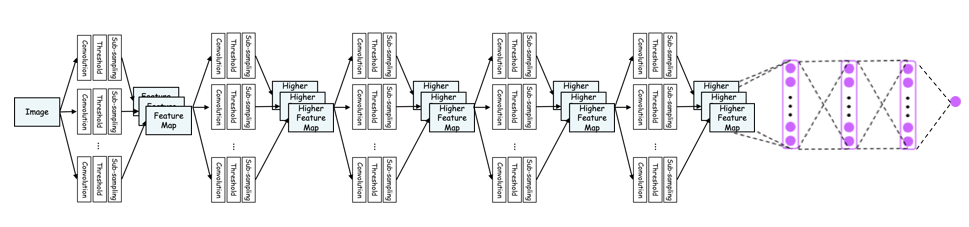

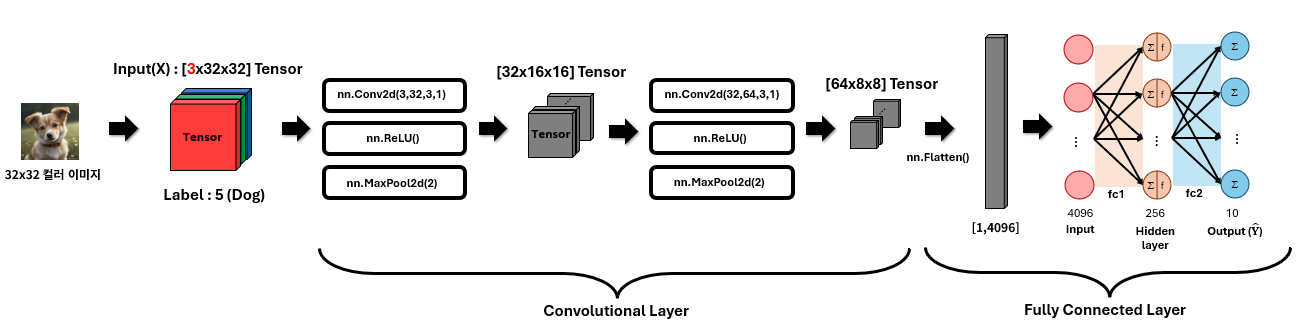

- CNN은 **Convolutional Layer**와 **Fully Connected Layer** 들로 이루어짐
  - Convolutional Layer
    - Convolution : 작은 필터(Kernel)를 이미지 위에서 움직이며(=Kernel로 이미지를 슬라이딩하며), 내적&채널 별 합산을 통해 이미지의 특징(Feature Map)을 뽑아내는 연산을 함
    - Threshold : 뽑아낸 특징들 중 일정 수준 이상으로 크기가 큰 값만 남김
    - Pooling : 이미지에서 중요한 부분만 남기고 크기를 줄여줌
  - Fully Conencted Layer는 일반적인 Neural Network와 동일함

- `nn.Module`을 상속받고 두 함수에 모델의 구조를 작성하는 것 까지는 동일
- Fully Connected Layer는 `nn.Linear`와 `nn.ReLU`로 구성됨
- Convolution Layer의 경우, 아래와 같은 layer들로 구성됨


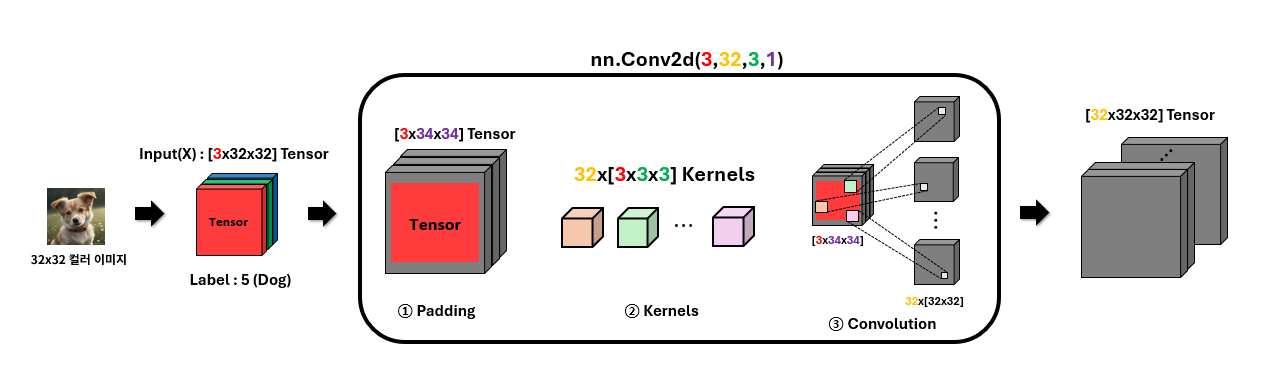


1. `nn.Conv2d(in_channels, out_channels, kernel_size, padding)` : Convolution을 담당하는 layer
  - `in_channels` : 입력되는 Tensor의 Channel 수, kernel의 channel 수와 동일함
  - `out_channels` : 출력될 Tensor의 Channels 수, kernel의 개수와 동일함
  - `kernel_size` : kernel의 크기
  - `padding` : padding 크기
  - 동작 과정
    - ① 입력 Tensor가 들어옴
    - ② `padding` 만큼 padding을 적용
    - ③ [`in_channels`,`kernel_size`,`kernel_size`] 크기의 kernel을 `out_channels`개 만큼 준비
    - ④ padding이 적용된 입력 Tensor를 준비한 kernel들로 convolution (Kernel로 이미지를 슬라이딩하며 내적 및 채널 별 합산) 진행
      - Kernel 하나당 1개의 Feature Map이 나옴
      - 총 `out_channels`개 만큼의 Feature Map이 나옴
      - Feature Map의 크기는 아래의 공식을 따름
    - 최종적으로 [`out_channels`,`feature_map 높이`,`feature_map 너비`] 크기의 출력 Tensor를 얻을 수 있음

    - Convolution 이후 출력되는 Tensor(Feature Map)의 크기

    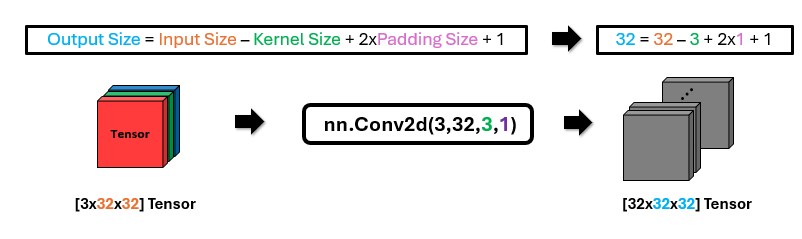
  </details>

- Exercise 1

  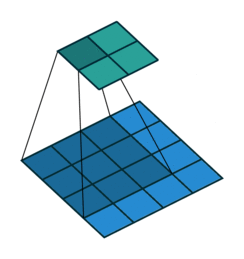

  - 위의 그림과 같은 Convolution이 이루어지도록 nn.Conv2d를 생성하고 output tensor의 크기를 확인하기
  - 입력되는 Tensor와 출력될 Tensor의 Channel 수는 모두 1이라고 가정
  - 적절한 kernel_size 및 padding 을 결정하기

In [ ]:
# ?에 값을 채워 넣어주세요!

input = torch.ones(1,?,?) # input tensor의 크기

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=?, padding=?) # 적절한 kernel size와 padding

output = conv_layer(input)

if (1,?,?) == output.shape: # output tensor의 크기
  print('Correct!!')
else:
  print('Try Again..')

True

- Exercise2

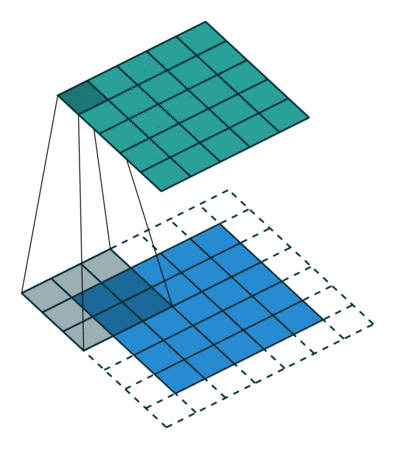

  - 위의 그림과 같은 Convolution이 이루어지도록 nn.Conv2d를 생성하고 output tensor의 크기를 확인하기
  - 입력되는 Tensor와 출력될 Tensor의 Channel 수는 모두 1이라고 가정
  - 적절한 kernel_size 및 padding 을 결정하기

In [ ]:
# ?에 값을 채워 넣어주세요!

input = torch.ones(1,?,?) # input tensor의 크기

conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=?, padding=?) # 적절한 kernel size와 padding

output = conv_layer(input)

if (1,?,?) == output.shape: # output tensor의 크기
  print('Correct!!')
else:
  print('Try Again..')

Correct!!


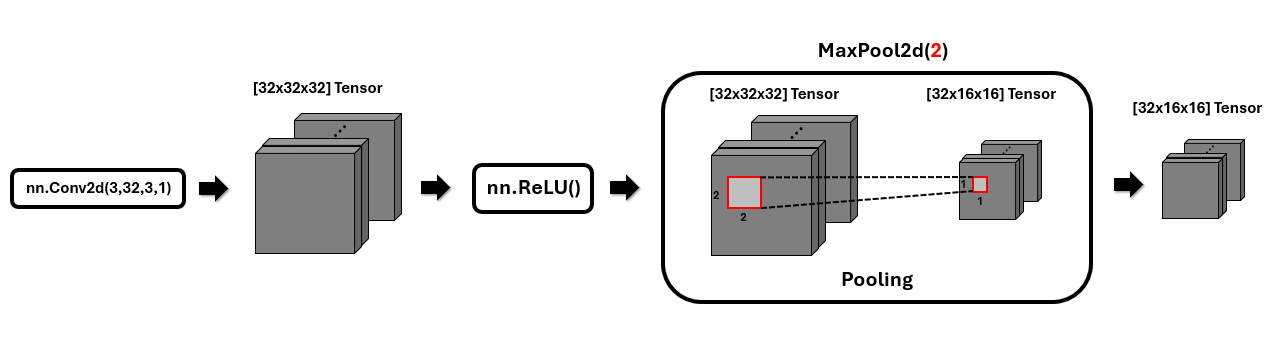

  
- `nn.ReLU()` : Threshold를 담당하는 layer
- `nn.MaxPool2d(kernel_size)` : Pooling을 담당하는 layer
  - `kernel_size` : pooling에 사용될 kernel의 크기
  - 동작 과정
    - ① [`C`,`H`,`W`] 크기의 입력 Tensor가 들어옴
    - ② kernel로 이미지를 슬라이딩 하며 kernel 내부의 값 중 가장 큰 값을 뽑음
    - ③ 최종적으로 [`C`,`H/kernel_size`,`W/kernel_size`] 크기의 출력 Tensor를 내보냄


In [6]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

#### 2.2 학습 및 평가


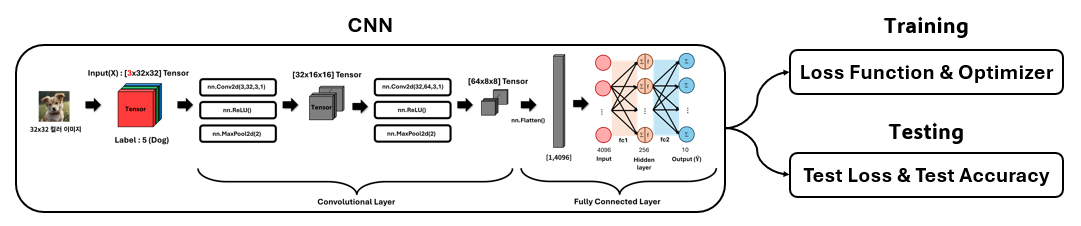

- 학습과 평가는 일반적인 Neural Network와 다르지 않음

In [14]:
def train_eval(model, optimizer, train_loader, test_loader, device, epochs=10):
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # 학습
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 평가
        model.eval()
        total = 0
        correct = 0
        total_test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                total_test_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct / total

        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy*100:.2f}%")

    return train_losses, test_losses, test_accuracies


- `summary(model, input_shape)` 함수를 통해 각 layer의 출력 Tensor의 shape을 직접 계산하지 않고도 확인할 수 있음

In [18]:
# 모델 생성 및 준비
model = CIFAR_CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                  [-1, 256]       1,048,832
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 1,070,794
Trainable params: 1,070,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.88
Params size (MB): 4.08
Estimat

In [19]:
# 학습 및 평가
set_seed(42)
train_losses, test_losses, test_accuracies = train_eval(model, optimizer, train_loader, test_loader, device, epochs=10)

Epoch 1/10 | Train Loss: 1.3127 | Test Loss: 1.0376 | Test Acc: 63.40%
Epoch 2/10 | Train Loss: 0.9392 | Test Loss: 0.9389 | Test Acc: 67.64%
Epoch 3/10 | Train Loss: 0.7726 | Test Loss: 0.8667 | Test Acc: 69.75%
Epoch 4/10 | Train Loss: 0.6453 | Test Loss: 0.8141 | Test Acc: 71.65%
Epoch 5/10 | Train Loss: 0.5237 | Test Loss: 0.8759 | Test Acc: 71.55%
Epoch 6/10 | Train Loss: 0.4097 | Test Loss: 0.8900 | Test Acc: 71.64%
Epoch 7/10 | Train Loss: 0.3059 | Test Loss: 0.9708 | Test Acc: 71.84%
Epoch 8/10 | Train Loss: 0.2210 | Test Loss: 1.0714 | Test Acc: 72.06%
Epoch 9/10 | Train Loss: 0.1592 | Test Loss: 1.2021 | Test Acc: 71.87%
Epoch 10/10 | Train Loss: 0.1233 | Test Loss: 1.3320 | Test Acc: 71.66%


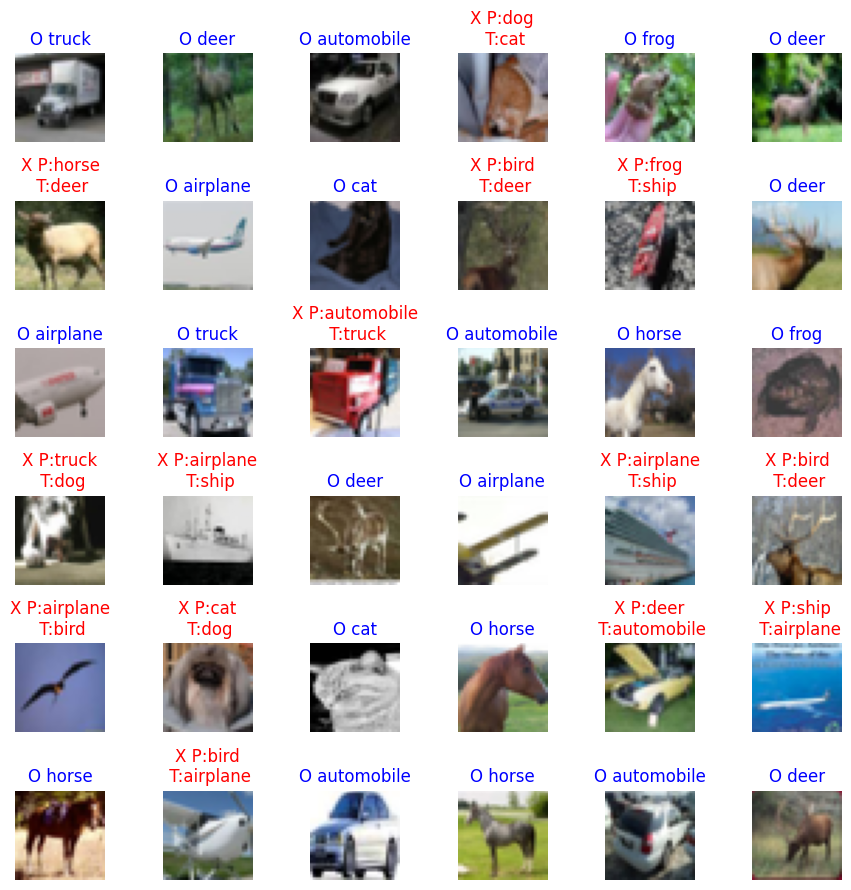

In [20]:
# 예측 결과 시각화

# CIFAR-10 클래스 이름
labels_map = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 모델 시각화용 출력 함수
def visualize_predictions(model, test_dataset, device, rows=6, cols=6):
    fig = plt.figure(figsize=(1.5 * cols, 1.5 * rows))
    model.eval()

    for i in range(1, rows * cols + 1):
        data_idx = np.random.randint(len(test_dataset))

        # 이미지 + 라벨 불러오기
        img, true_label = test_dataset[data_idx]
        input_img = img.unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            output = model(input_img)
            _, predicted = output.max(1)

        pred_label = predicted.item()
        true_label = true_label
        pred_name = labels_map[pred_label]
        true_name = labels_map[true_label]

        # 시각화
        ax = fig.add_subplot(rows, cols, i)
        npimg = img.numpy()
        npimg = (np.transpose(npimg, (1, 2, 0)) * 0.5) + 0.5  # unnormalize

        ax.imshow(npimg)
        if pred_label == true_label:
            ax.set_title(f"O {pred_name}", color='blue')
        else:
            ax.set_title(f"X P:{pred_name}\n T:{true_name}", color='red')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, testset, device, rows=6, cols=6)